In [6]:
library(tidyverse)
library(repr)
library(tidymodels)
library(ggplot2)

**Question used: Question 2: We would like to know which kinds of players are most likely to contribute a large amount of data so that we can target 
those players in our recruiting efforts.**

1. Data description

We are given 2 datasets that explain the data and sessions of each player. This data is used to predict and target which kinds of players are most likely to contribute a large amount of data. 

**players.csv has 196 observations, 7 variables:**

- *experience: Pro, Veteran, Amateur, Regular, Beginner, Veteran, Pro* [chr]
------ whether a player is experienced or not
- *subscribe: TRUE, FALSE* [lgl]
------ wwhether a player is subscribed
- *hashedEmail* [chr]
------ who is playing, player ID 
- *played_hours* [dbl]
------ number of hours played, integer
- *name* [chr]
------ player's name, 
- *gender: Male, Female, Non-Binary, Prefer not to say, Agender, Two-Spirited, Other* [chr]
------ player's gender 
- *age* [int]
------ player's age, **2 NAs**

*played_hours summary statistics:* 
- mean: 5.85

*age summary statistics*
- mean: 21.14
  
players.csv is tidy because it is human readable and is very clear with what each column is trying to convey.

**sessions.csv has 1535 observations, 5 variables:**
- *hashedEmail* [chr]
------ who is playing, player ID
- *start_time (DD/MM/YYYY Hours: Minutes)* [chr]
------ time at which the player starts playing the game 
- *end_time (DD/MM/YYYY Hours: Minutes)* [chr]
------ time at which the player stops playing the game 
- *original_start_time (milliseconds)* [dbl]
------ raw timestamp at which the player starts playing the game
- *original_end_time (milliseconds)* [dbl]
------ raw timestamp at which the player stops playing the game, **2 NAs**

*original_start_time (milliseconds) summary statistics*
- mean: 1.719e+12


*original_end_time (milliseconds) summary statistics*
- mean: 1.719e+12

sessions.csv is not tidy because the decimal values for the original start and end times are hard for a human to interpret. The duplicate of both times is also redundant. 


**2. Questions:**

***Broad question:*** 
We would like to know which kinds of players are most likely to contribute a large amount of data so that we can target those players in our recruiting efforts. 

***Specific question:***
Can player information such as experience level, gender, and subscriber status predict the total number of hours played in the game?


I chose kknn because it captures non-linear relationships between played_hours and categorical variables like experience, gender, and subscriber status. The ultimate goal here is to predict whether explanatory variables, experience, gender, and subscriber status can predict how long a player spends in a game, as players who play longer will contribute more data. 

For wrangling, the experience, gender, and subscriber variables should be converted to factors, get rid of the NAs by using the na.rm function, split the data into training and testing sets into 80/20, and use cross-validation to tune k in the training set. 

**3. Exploratory Data Analysis and Visualization**

In [7]:
options(repr.matrix.max.rows = 6)
players<- read_csv("players.csv")
sessions<- read_csv("sessions.csv")
players
sessions

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,57
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
⋮,⋮,⋮,⋮,⋮
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,28/07/2024 15:36,28/07/2024 15:57,1.72218e+12,1.72218e+12
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,25/07/2024 06:15,25/07/2024 06:22,1.72189e+12,1.72189e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,20/05/2024 02:26,20/05/2024 02:45,1.71617e+12,1.71617e+12


In [8]:
players <- players |>
    mutate(experience= as_factor(experience), gender = as_factor(gender), subscribe = as_factor(subscribe), age = as.numeric(Age))

players_mean_hrs_age<- players|>
    summarize(mean_hours = mean(played_hours, na.rm = TRUE), mean_age= mean(age, na.rm = TRUE))

sessions<- sessions |>
    mutate(original_start_time= as.numeric(original_start_time), original_end_time= as.numeric(original_end_time))

sessions_mean_start_end_times <- sessions |>
     summarize(mean_original_start_time= mean(original_start_time, na.rm = TRUE), mean_original_end_time= mean(original_end_time, na.rm = TRUE))


players_mean_hrs_age
sessions_mean_start_end_times

mean_hours,mean_age
<dbl>,<dbl>
5.845918,21.13918


mean_original_start_time,mean_original_end_time
<dbl>,<dbl>
1.719201e+12,1.719196e+12


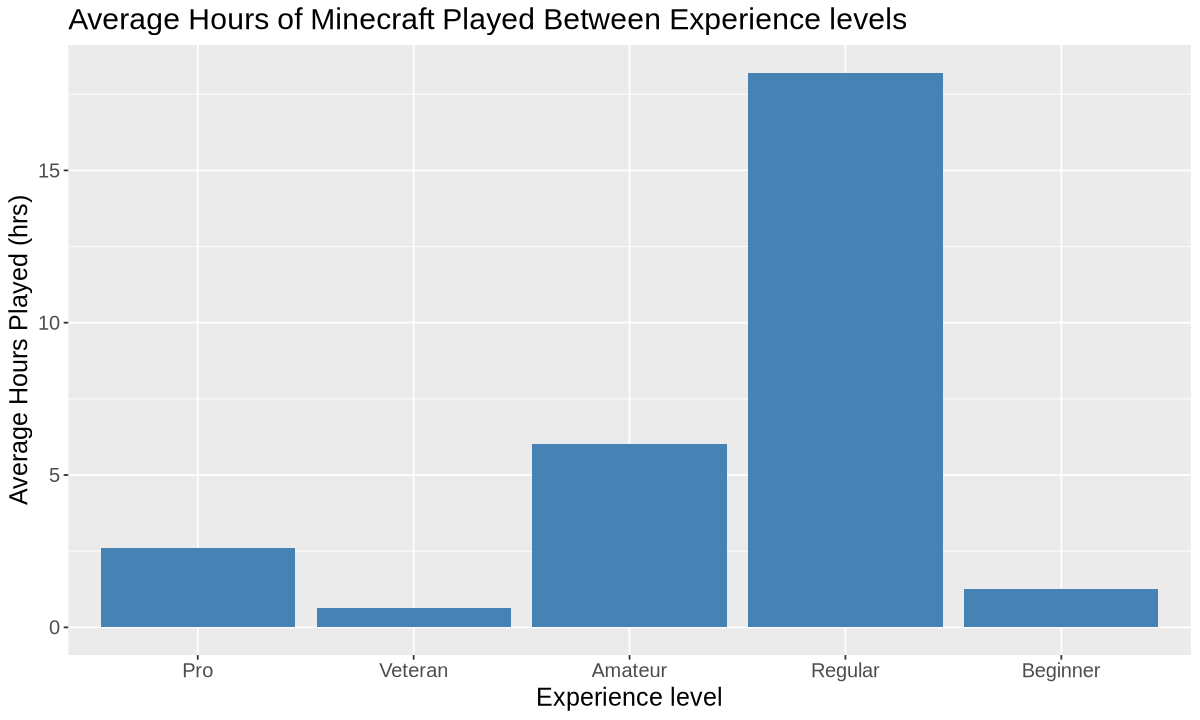

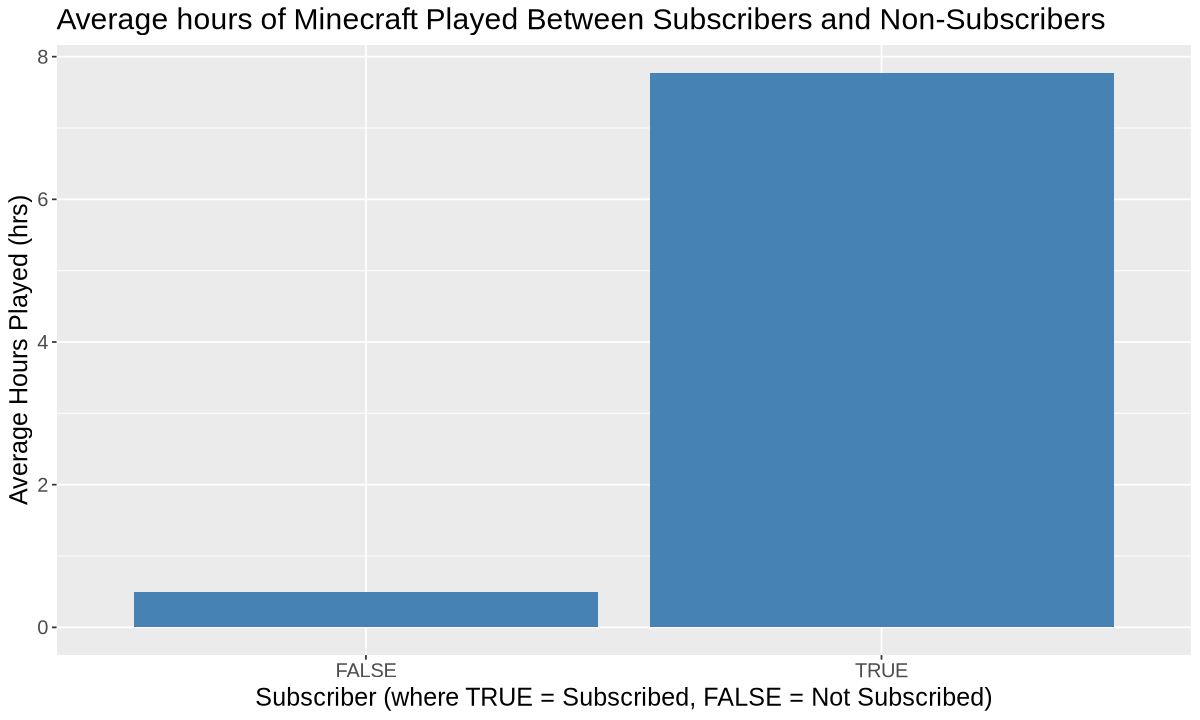

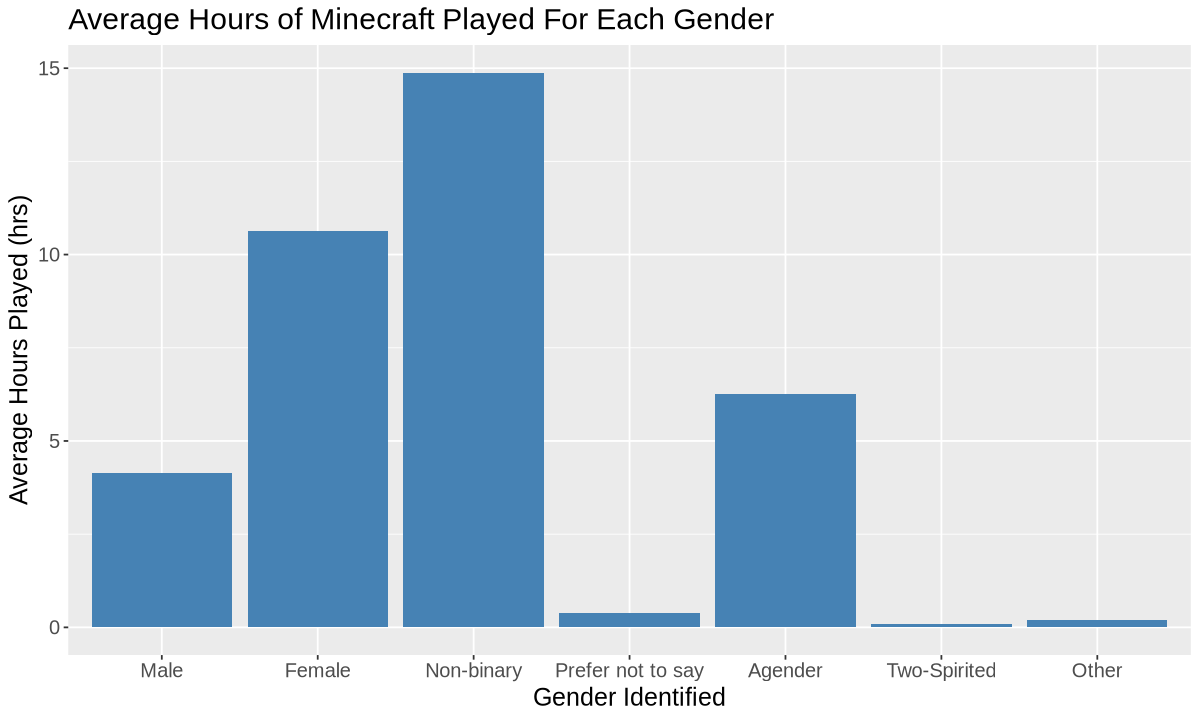

In [10]:
set.seed(2000) 
players_split<- initial_split(players, prop = 0.8, strata = played_hours)
players_training <- training(players_split)
players_testing <- testing(players_split) 

avg_exp <- players |>
  group_by(experience) |>
  summarize(mean_hours = mean(played_hours, na.rm = TRUE))

options(repr.plot.height =6, repr.plot.width=10)
hrs_vs_exp <- ggplot(avg_exp, aes(x=experience, y = mean_hours)) + 
    geom_bar(stat = "identity", fill = "steelblue") +
    labs(title = "Average Hours of Minecraft Played Between Experience levels", 
       x = "Experience level", 
       y = "Average Hours Played (hrs)") +
     theme(text = element_text(size = 15)) 
 
hrs_vs_exp


avg_sub <- players |>
  group_by(subscribe) |>
  summarize(mean_hours = mean(played_hours, na.rm = TRUE))

options(repr.plot.height =6, repr.plot.width=10)
hrs_vs_sub <- ggplot(avg_sub, aes(x=subscribe, y = mean_hours)) + 
    geom_bar(stat = "identity", fill = "steelblue") + 
    labs(title = "Average hours of Minecraft Played Between Subscribers and Non-Subscribers", 
         x = "Subscriber (where TRUE = Subscribed, FALSE = Not Subscribed)", 
         y = "Average Hours Played (hrs)")+
    theme(text = element_text(size = 15)) 
 
hrs_vs_sub


avg_gender <- players |>
  group_by(gender) |>
  summarize(mean_hours = mean(played_hours, na.rm = TRUE))

options(repr.plot.height =6, repr.plot.width=10)
hrs_vs_gender <- ggplot(avg_gender, aes(x=gender, y = mean_hours)) + 
    geom_bar(stat = "identity", fill = "steelblue") + 
    labs(title = "Average Hours of Minecraft Played For Each Gender", 
         x = "Gender Identified", 
         y = "Average Hours Played (hrs)")+
    theme(text = element_text(size = 15)) 
 
hrs_vs_gender


Experience level: Regular experience players play more average hours.

Subscribed: Average hours of subscribed players dominate non-subscribers.

Gender: Average hours for Non-binary dominates.

**4. Methods and Plan**

I will use KNN because it relates non-linear categorical variables and numeric values. Assumptions include independent observations and similar distributions in training and test sets. Limitations was averaging hours for graphs due to outliers. I will tune k with cross-validation and check accuracy with RMSE. Categories will be converted to factors, and the data split 80/20 before training.